LightGBM Quickstart for the American Express - Default Prediction competition

This notebook shows how to apply LightGBM to the competition data, and it introduces a space-efficient way of feature engineering.

https://www.kaggle.com/code/cliviakong/amex-lightgbm-quickstart/edit

# Install and Import libraries 

In [ ]:
! pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 27165, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 27165 (delta 164), reused 204 (delta 127), pack-reused 26891
Receiving objects: 100% (27165/27165), 19.53 MiB | 13.98 MiB/s, done.
Resolving deltas: 100% (20078/20078), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remote: Co

In [ ]:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Found Boost: /usr/include (found suitable version "1.65.1", minimum required is "1.56.0") found components: filesystem system 
-- Performing Test MM_PREFET

In [ ]:
#!pip install wandb

In [ ]:
#!pip install -Uq 'lightgbm>=3.3.1'

In [ ]:
#import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import warnings
from colorama import Fore, Back, Style
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
from lightgbm import LGBMClassifier
#from wandb.lightgbm import wandb_callback
from lightgbm import LGBMClassifier, log_evaluation

#plt.rcParams['axes.facecolor'] = '#0057b8' # blue
#plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
#plt.rcParams['text.color'] = 'w'

INFERENCE = True # set to False if you only want to cross-validate


In [ ]:
#wandb.login()

In [ ]:
# From https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading and preprocessing the data

Then we create three groups of features:
- Selected features averaged over all statements of a customer
- The minimum or maximum of selected features over all statements of a customer
- Selected features taken from the last statement of a customer

The code has been optimized for memory efficiency rather than readability. In particular, `.iloc[mask_array, columns]` needs much less RAM than the groupby construction used in a previous version of the notebook.

Preprocessing for LightGBM is much simpler than for neural networks:
1. Neural networks can't process missing values; LightGBM handles them automatically.
1. Categorical features need to be one-hot encoded for neural networks; LightGBM handles them automatically.
1. With neural networks, you need to think about outliers; tree-based algorithms deal with outliers easily.
1. Neural networks need scaled inputs; tree-based algorithms don't depend on scaling.

%%time   prints wall time for the entire cell

In [ ]:
%%time

features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']
features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_29', 'B_33', 'B_36', 'B_42', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_71', 'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_9', 'S_11', 'S_12', 'S_23', 'S_25']
features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_102', 'D_105', 'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
for i in ['test', 'train'] if INFERENCE else ['train']:
    df = pd.read_parquet(f'/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition/{i}.parquet')
    #df = pd.read_parquet(f'../input/amex-data-integer-dtypes-parquet-format/{i}.parquet')
    cid = pd.Categorical(df.pop('customer_ID'), ordered=True)
    last = (cid != np.roll(cid, -1)) # mask for last statement of every customer
    if 'target' in df.columns:
        df.drop(columns=['target'], inplace=True)
    gc.collect()
    print('Read', i)
    df_avg = (df
              .groupby(cid)
              .mean()[features_avg]
              .rename(columns={f: f"{f}_avg" for f in features_avg})
             )
    gc.collect()
    print('Computed avg', i)
    df_min = (df
              .groupby(cid)
              .min()[features_min]
              .rename(columns={f: f"{f}_min" for f in features_min})
             )
    gc.collect()
    print('Computed min', i)
    df_max = (df
              .groupby(cid)
              .max()[features_max]
              .rename(columns={f: f"{f}_max" for f in features_max})
             )
    gc.collect()
    print('Computed max', i)
    df = (df.loc[last, features_last]
          .rename(columns={f: f"{f}_last" for f in features_last})
          .set_index(np.asarray(cid[last]))
         )
    gc.collect()
    print('Computed last', i)
    df = pd.concat([df, df_min, df_max, df_avg], axis=1)
    if i == 'train': train = df
    else: test = df
    print(f"{i} shape: {df.shape}")
    del df, df_avg, df_min, df_max, cid, last

#target = pd.read_csv('../input/amex-default-prediction/train_labels.csv').target.values
target = pd.read_csv( '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition/train_labels.csv').target.values 
print(f"target shape: {target.shape}")

Read test
Computed avg test
Computed min test
Computed max test
Computed last test
test shape: (924621, 469)
Read train
Computed avg train
Computed min train
Computed max train
Computed last train
train shape: (458913, 469)
target shape: (458913,)
CPU times: user 6min 20s, sys: 1min 16s, total: 7min 37s
Wall time: 7min 16s


# Cross-validation

We cross-validate with a five-fold StratifiedKFold because the classes are imbalanced.

Notice that lightgbm logs the validation score with the competition's scoring function every hundred iterations.

In [ ]:
class CFG:
    seed = 42
    n_estimators = 1000       #1200
    learning_rate = 0.01       #0.03
    reg_lambda = 50   #50
    min_child_samples = 2400   #2400
    num_leaves = 95    # 95
    colsample_bytree = 0.19   #0.19
    max_bins = 511      #511
    max_depth = 5
    min_child_weight = 6   


In [ ]:
%%time
# Cross-validation of the classifier

ONLY_FIRST_FOLD = False

features = [f for f in train.columns if f != 'customer_ID' and f != 'target']

def my_booster(random_state= CFG.seed, n_estimators=CFG.n_estimators):
    return LGBMClassifier(n_estimators=n_estimators,
                          learning_rate = CFG.learning_rate, reg_lambda = CFG.reg_lambda,
                          min_child_samples = CFG.min_child_samples,
                          min_child_weight = CFG.min_child_weight,
                          max_depth = CFG.max_depth,
                          num_leaves= CFG.num_leaves,
                          colsample_bytree= CFG.colsample_bytree,
                          max_bins= CFG.max_bins , random_state=random_state)
      
print(f"{len(features)} features")
score_list = []
y_pred_list = []
kf = StratifiedKFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, target)):
    X_tr, X_va, y_tr, y_va, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = target[idx_tr]
    y_va = target[idx_va]
    
    model = my_booster()
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_tr, y_tr,
                  eval_set = [(X_va, y_va)], 
                  eval_metric=[lgb_amex_metric],
                  #callbacks=[wandb_callback(100)])
                  callbacks=[log_evaluation(100)])
    X_tr, y_tr = None, None
    y_va_pred = model.predict_proba(X_va, raw_score=True)
    score = amex_metric(y_va, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    
    if INFERENCE:
        y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    if ONLY_FIRST_FOLD: break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# Prediction histogram

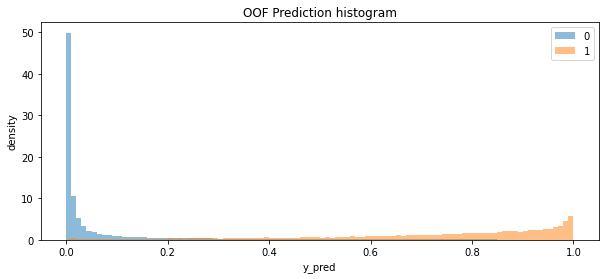

In [ ]:
def sigmoid(log_odds):
    return 1 / (1 + np.exp(-log_odds))

plt.figure(figsize=(10, 4))
plt.hist(sigmoid(y_va_pred[y_va == 0]), bins=np.linspace(0, 1, 101),
         alpha=0.5, density=True, label='0')
plt.hist(sigmoid(y_va_pred[y_va == 1]), bins=np.linspace(0, 1, 101),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='k')
plt.legend()
plt.show()

# Calibration diagram

The calibration diagram shows how the model predicts the default probability of customers:

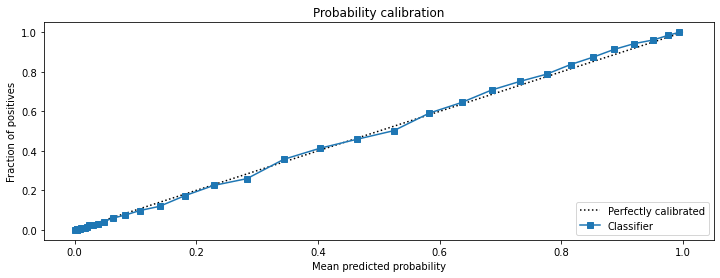

In [ ]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, sigmoid(y_va_pred), n_bins=50,
                                    strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

# Submission

submit the mean of the five predictions. 

As a final check, we verify that the test prediction distribution equals the validation prediction distribution. 

In [ ]:
path = '/content/drive/MyDrive/Amex_Default_Prediction_Kaggle_Competition'

In [22]:
if INFERENCE:
    sub = pd.DataFrame({'customer_ID': test.index,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub_1 = sub.copy()
    condition1 = sub_1['prediction'] > 0
    sub_1['prediction'] = condition1
    sub_1['prediction'] = sub_1['prediction'].map({True:'1', False: '0'})
    sub.to_csv(path+ '/submission_200822_quickstart_paramsADD_0.csv', index=False)
    sub_1.to_csv(path+ '/submission_200822_quickstart_params_sub1_ADD_0.csv', index=False)
    display(sub)
    display(sub_1)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-2.805058
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-5.756230
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-3.463004
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-0.631969
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.552769
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-3.628242
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.553462
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.471149
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-0.449540


,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,1
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0


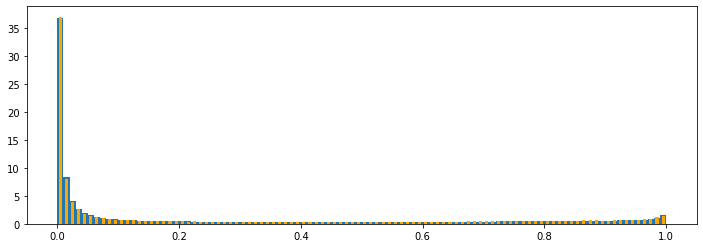

In [23]:
plt.figure(figsize=(12, 4))
plt.hist(sigmoid(sub.prediction), bins=np.linspace(0, 1, 101), density=True)
plt.hist(sigmoid(y_va_pred), bins=np.linspace(0, 1, 101), rwidth=0.5, color='orange', density=True)
plt.show()